# 2021 STA Plate Scale Analysis

Cross-match our starlists with the Gaia catalog and fit for a plate scale.

In [5]:
import numpy as np
import pylab as plt
from flystar import align, plots
from flystar import analysis
from flystar import starlists
from flystar import startables
from astropy.table import Table
from datetime import datetime
import time
from astropy.io import fits
import os

### Query Gaia for the field around our Fld2 position.

In [6]:
ra = '19:33:44.8376'
dec = '07:49:45.760'
search_rad = 15.0 * 60.0 # 15 arcmin


Prepare the Gaia table for FlyStar ingestion. This will make a new table with relative offsets and flip the sign convention to +x increasing to the West.

In [9]:
gaia = analysis.query_gaia(ra, dec, search_radius=search_rad, table_name='gaiaedr3')

if not os.path.exists('fld2_gaia_tan_project.fits'):
    gaia = analysis.query_gaia(ra, dec, search_radius=search_rad, table_name='gaiaedr3')
    print(f'Found {len(gaia)} Gaia stars')

    mygaia = analysis.prepare_gaia_for_flystar(gaia, ra, dec)

    # STA images actually come out flipped and don't look like the sky. 
    # So lets stick with +x increases to the East.
    mygaia['x0'] *= -1.0
    mygaia['vx'] *= -1.0

    # Save the table so we don't have to reduce the query.
    mygaia.write('fld2_gaia_tan_project.fits', overwrite=True)
else:
    mygaia = Table.read('fld2_gaia_tan_project.fits')
    mygaia['name'] = mygaia['name'].astype('S20')

INFO: Query finished. [astroquery.utils.tap.core]


Plot up the Gaia stars, and there parallax and proper motion vectors.

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

(-14.466267294404268,
 14.445212867349621,
 -14.452656493108668,
 14.477125062127715)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Bitstream Vera Sans
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Bitstream Vera Sans


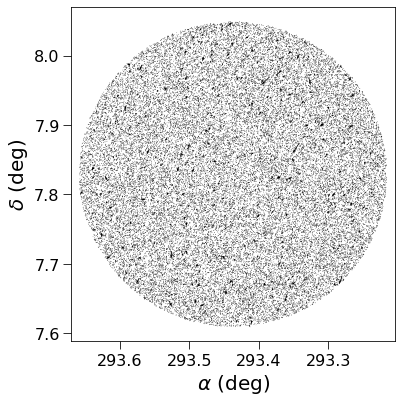

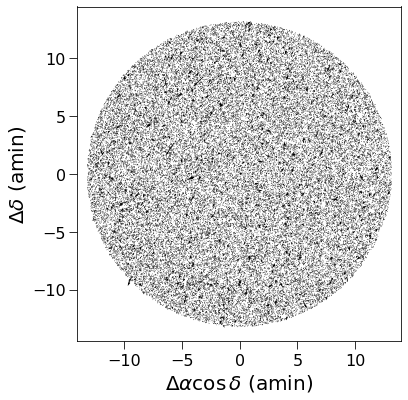

In [10]:
print(gaia.colnames)

plt.figure(1, figsize=(6,6))
plt.quiver(gaia['ra'].data, gaia['dec'].data, gaia['pmra'].data, gaia['pmdec'].data)
plt.xlabel(r'$\alpha$ (deg)')
plt.ylabel(r'$\delta$ (deg)')
plt.axis('equal')
plt.gca().invert_xaxis()

plt.figure(2, figsize=(6,6))
plt.quiver(mygaia['x0']/60., mygaia['y0']/60., mygaia['vx'], mygaia['vy'])
plt.xlabel(r'$\Delta \alpha \cos \delta$ (amin)')
plt.ylabel(r'$\Delta \delta$ (amin)')
plt.axis('equal')

### Read in the imaka STA starlists
We will use the data from 2021-04-29, which is 2x2 binned mode.

In [11]:
def toDecimalYear(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

The data from 2021-04-29 is taken with the STA camera in 2x2 binned mode.

In [12]:
starlist_file = '/Users/jlu/data/imaka/onaga/20210429/sta/reduce/stacks/fld2_stack_LS_c_stars_stats_mdp.fits'
image_file = '/Users/jlu/data/imaka/onaga/20210429/sta/reduce/stacks/fld2_stack_LS_c.fits'

stars = Table.read(starlist_file)
stars = stars['id', 'xcentroid', 'ycentroid', 'mag', 'flux']
stars.rename_column('xcentroid', 'x')
stars.rename_column('ycentroid', 'y')
stars.rename_column('id', 'name')
stars.rename_column('mag', 'm')
stars['name'] = stars['name'].astype('S10')

year = toDecimalYear( datetime.strptime('2014-04-29', '%Y-%m-%d') )
stars['t'] = np.repeat(year, len(stars))

print(f'Starlist contains {len(stars)} stars.')

stars = starlists.StarList(stars)

Starlist contains 2026 stars.


/Users/jlu/pycode/flystar/flystar/starlists.py:390: UserWarning: The StarList class requires a arguments('name', 'x', 'y', 'm')
  warnings.warn(err_msg, UserWarning)


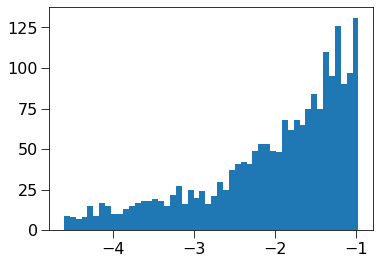

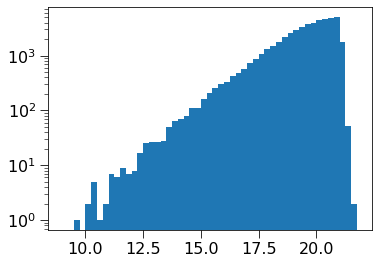

In [13]:
plt.figure(1)
plt.clf()
foo = plt.hist(stars['m'], bins=50)

plt.figure(2)
plt.clf()
foo = plt.hist(mygaia['m'], bins=np.arange(9, 22, 0.25), log=True)

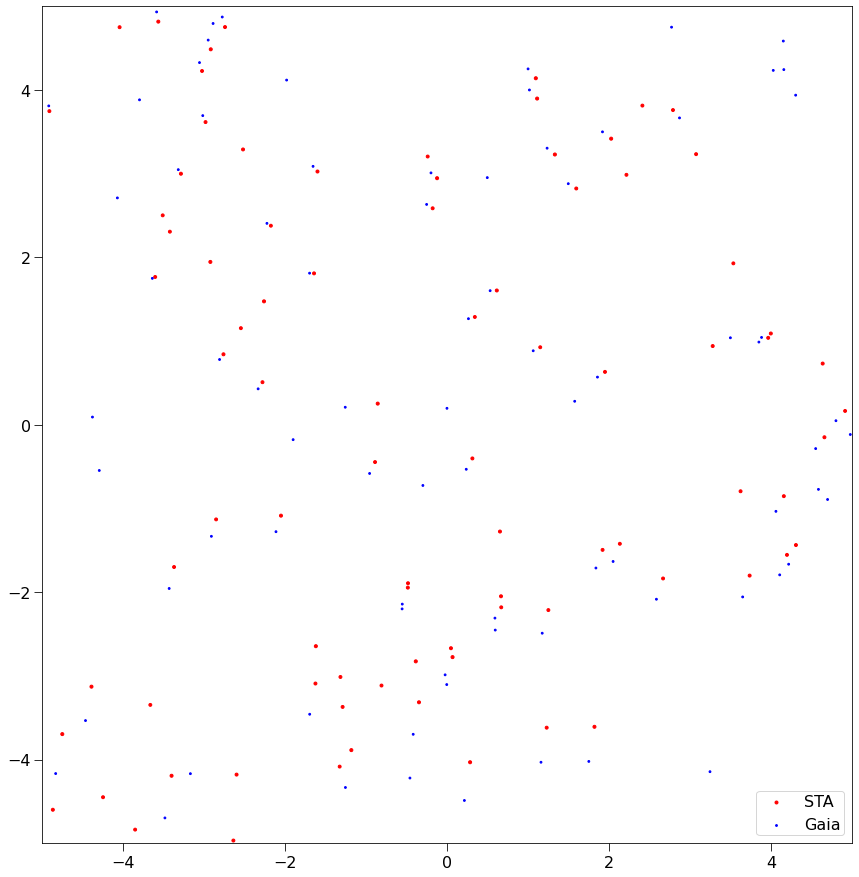

In [14]:
scale = stars.meta['SCALE'] # arcsec per pixel.
scale /= 60.0

xs = (stars['x'] - stars['x'].mean()) * scale
ys = (stars['y'] - stars['y'].mean()) * scale

plt.figure(figsize=(15, 15))
plt.clf()

idx = np.where(stars['m'] < -4)[0]
plt.scatter(xs[idx], ys[idx], s=(1./(stars['m'][idx] + 10))*50, c='red', label='STA')

idx = np.where((mygaia['m'] > 15) & (mygaia['m'] < 15.5))[0]
plt.scatter(mygaia['x0'][idx] / 60.0, mygaia['y0'][idx] / 60.0, s=(1.0/mygaia['m'][idx])*50, c='blue', label='Gaia')

plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.legend()

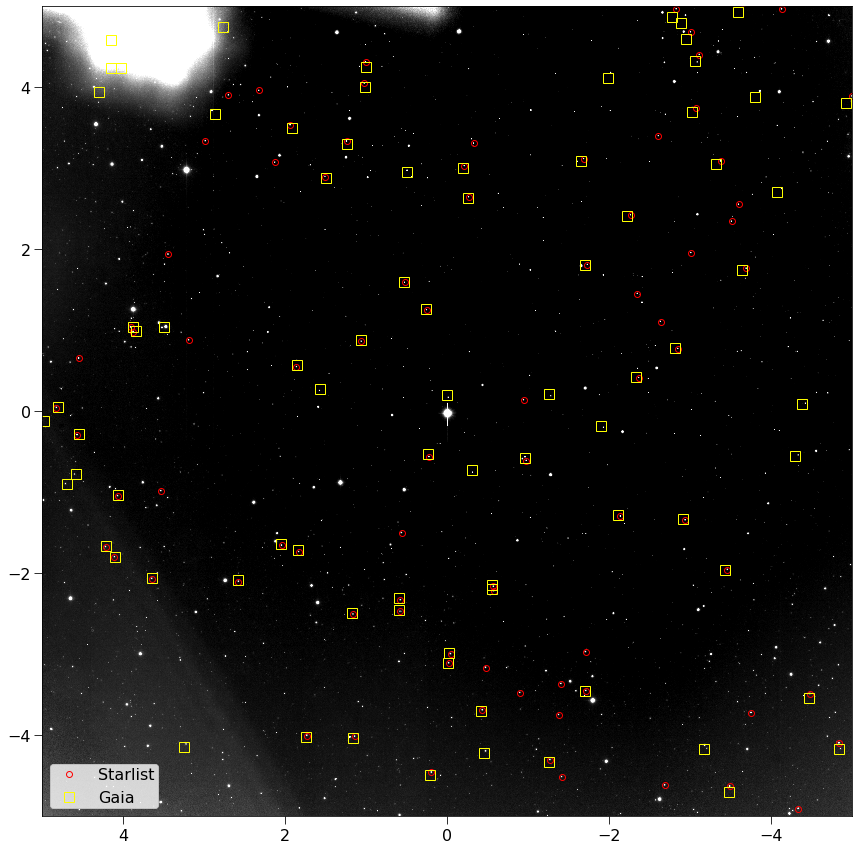

In [15]:
img, hdr = fits.getdata(image_file, header=True)

xscale = scale
yscale = 1.073 * scale
xref = 2525
yref = 2810

x_arc = (stars['x'] - xref) * xscale
y_arc = (stars['y'] - yref) * yscale

img_x_arc = (np.arange(img.shape[1]) - xref) * xscale
img_y_arc = (np.arange(img.shape[0]) - yref) * yscale
extent = [img_x_arc.min(), img_x_arc.max(), img_y_arc.min(), img_y_arc.max()]
plt.figure(figsize=(15, 15))
plt.imshow(img, vmin=0, vmax=2000, origin='lower', cmap=plt.cm.gray, extent=extent)

idx = np.where((stars['m'] > -8) & (stars['m'] < -4))[0]
plt.plot(x_arc[idx], y_arc[idx], 'ro', mec='red', mfc='none', label='Starlist')

gdx = np.where((mygaia['m'] > 15.0) & (mygaia['m'] < 15.5))[0]
plt.plot(mygaia['x0'][gdx]/60., mygaia['y0'][gdx]/60., 'bs', mec='yellow', mfc='none', label='Gaia', ms=10)
plt.gca().invert_xaxis()
plt.xlim(5, -5)
plt.ylim(-5, 5)
plt.legend()

Looks good above. Lets do some manual matching so we have a few things to latch onto.


In [16]:
ids_in_gaia = []
ids_in_slist = []

rad = np.hypot(x_arc[idx], y_arc[idx])
rdx = np.argsort(rad)

n_match = 0

for rr in rdx:
    idx_slist = idx[rr]
    
    dx = (mygaia[gdx]['x0'] / 60.0) - x_arc[idx_slist]
    dy = (mygaia[gdx]['y0'] / 60.0) - y_arc[idx_slist]
    dr = np.hypot(dx, dy) * 60.0 # in arcsec
    dr_mindx = dr.argmin()
    
    
    # Check that they are close enough
    if dr[dr_mindx] < 1.5:
        ids_in_gaia.append(gdx[dr_mindx])
        ids_in_slist.append(idx_slist)
        n_match += 1
        
        #print(mygaia[gdx][dr_mindx]['x0']/60.0, mygaia[gdx][dr_mindx]['y0']/60.0, mygaia[gdx][dr_mindx]['m'], 
        #      x_arc[idx_slist], y_arc[idx_slist], stars['m'][idx_slist])
        
    if n_match > 10:
        break

# Rename the matched sources and move them to the top
mygaia['name'][ids_in_gaia] = stars['name'][ids_in_slist]

ids_sort_gaia = list(range(len(mygaia)))
ids_sort_slist = list(range(len(stars)))

for ii in range(len(ids_in_gaia)):
    mygaia['name'][ids_in_gaia[ii]] = f'S{ii+1:03d}'
    stars['name'][ids_in_slist[ii]] = f'S{ii+1:03d}'
    
    ids_sort_gaia.remove(ids_in_gaia[ii])
    ids_sort_slist.remove(ids_in_slist[ii])
    
    ids_sort_gaia.insert(0, ids_in_gaia[ii])
    ids_sort_slist.insert(0, ids_in_slist[ii])
    
# Rearrange
print(stars[ids_in_slist])
print(x_arc[ids_in_slist], y_arc[ids_in_slist])
print(mygaia[ids_in_gaia]['name', 'x0', 'y0', 'm'])

stars_new = stars[ids_sort_slist]
mygaia_new = mygaia[ids_sort_gaia]

print(stars_new)
print(mygaia_new['name', 'x0', 'y0', 'm'])




name    x        y       m      flux           t         
---- -------- -------- ----- --------- ------------------
S001 2645.866 3365.216 -4.02 40.543667 2014.3231735159818
S002 3030.335  3192.95 -4.06 42.103835 2014.3231735159818
S003 2775.025 3515.954 -4.33  53.73762 2014.3231735159818
S004 3411.041 3052.819 -4.22 48.859032 2014.3231735159818
S005 2799.707 1776.183 -4.28 51.303977 2014.3231735159818
S006 3396.917  2040.15 -4.08 42.670568 2014.3231735159818
S007 2801.089 1713.354 -4.11 44.192541 2014.3231735159818
S008  3498.35 2074.869  -4.1 43.849208 2014.3231735159818
S009 2397.914 3983.519 -4.19 47.552271 2014.3231735159818
S010 3078.183 1697.629 -4.08 42.942613 2014.3231735159818
S011 2505.507 1480.669 -4.38  56.34231 2014.3231735159818
         x          
--------------------
 0.25381859999999995
           1.0612035
  0.5250525000000001
  1.8606861000000003
  0.5768846999999997
  1.8310256999999996
  0.5797868999999999
  2.0440349999999996
 -0.2668805999999995
           1.16

In [26]:
run1 = align.MosaicToRef(mygaia, [stars], iters=2,
                 dr_tol=[0.5, 0.25], dm_tol=[25, 25],
                 outlier_tol=[None, None],
                 trans_args=[{'order': 1}, {'order': 1}],
                 mag_trans=False, ref_mag_lim=[15, 18],
                 use_vel=True, update_ref_orig=False,
                 init_guess_mode='name',
                 verbose=True)

run1.fit()

Parameters used for fit: 
------------------------- 
  dr_tol = [0.5, 0.25]
  dm_tol = [25, 25]
  outlier_tol = [None, None]
  trans_args = [{'order': 1}, {'order': 1}]
  mag_trans = False
  mag_lim = [[None None]]
  ref_mag_lim = [15, 18]
  weights = None
  n_boot = 0
  boot_epochs_min = -1
  trans_input = None
  trans_class = <class 'flystar.transforms.PolyTransform'>
  calc_trans_inverse = False
  use_ref_new = False
  use_vel = True
  update_ref_orig = False
  init_guess_mode = name
  iter_callback = None
-------------------------

 
**********
**********
Starting iter 0 with ref_table shape: (50000, 1)
**********
**********
 
   **********
   Matching catalog 1 / 1 with 2026 stars
      dr       < 0.500
      |dm|     < 25.000
      outlier tol:  None
          mag_lim:  [None None]
   **********
initial_guess: 11 stars matched between starlist and reference list
init guess:  [-3.14470973e+02  1.25124668e-01 -2.56805473e-04] [-3.81812399e+02  1.13794153e-03  1.35003229e-01]
    Fo

In [27]:
tab1 = run1.ref_table

# Get out only the stars that have detections and matches in the reference list.
#idx = np.where((tab1['n_detect'] > 0) & (tab1['ref_orig'] == True))[0]
idx = np.where((tab1['n_detect'] > 0))[0]


tab1_t = tab1[idx]

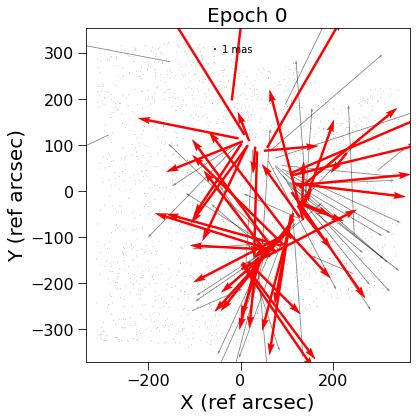

Residuals (mean, std): dx =  -7.981 +/- 106.796 mas  dy =  -8.672 +/- 114.839 mas for REF stars
Residuals (mean, std): dx =   0.175 +/-  24.866 mas  dy =  -1.064 +/-  27.672 mas for GOOD stars


In [28]:
plots.plot_quiver_residuals_all_epochs(tab1_t, scale=500)

In [29]:
print(run1.trans_list[0].px, run1.trans_list[0].py)

Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1         
    ------------------ ------------------- ----------------------
    -314.3858332672516 0.12510622080771613 -0.0002774738557644227 Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
            c0_0                 c1_0                 c0_1       
    ------------------- --------------------- -------------------
    -381.52265177700514 0.0010510137763111045 0.13501771522966116


### 2nd pass -- higher order

In [31]:
trans_list = run1.trans_list

run2 = align.MosaicToRef(mygaia, [stars], iters=2,
                 dr_tol=[0.5, 0.15], dm_tol=[25, 25],
                 outlier_tol=[None, None],
                 trans_args=[{'order': 2}, {'order': 2}],
                 trans_input=trans_list,
                 mag_trans=False, ref_mag_lim=None,
                 use_vel=True, update_ref_orig=False,
                 init_guess_mode='name',
                 verbose=True)

run2.fit()

Parameters used for fit: 
------------------------- 
  dr_tol = [0.5, 0.15]
  dm_tol = [25, 25]
  outlier_tol = [None, None]
  trans_args = [{'order': 2}, {'order': 2}]
  mag_trans = False
  mag_lim = [[None None]]
  ref_mag_lim = None
  weights = None
  n_boot = 0
  boot_epochs_min = -1
  trans_input = [<flystar.transforms.PolyTransform object at 0x7f94a0acdb50>]
  trans_class = <class 'flystar.transforms.PolyTransform'>
  calc_trans_inverse = False
  use_ref_new = False
  use_vel = True
  update_ref_orig = False
  init_guess_mode = name
  iter_callback = None
-------------------------

 
**********
**********
Starting iter 0 with ref_table shape: (50000, 1)
**********
**********
 
   **********
   Matching catalog 1 / 1 with 2026 stars
      dr       < 0.500
      |dm|     < 25.000
      outlier tol:  None
          mag_lim:  [None None]
   **********
    Found 0 duplicates out of 211 matches
  Match 1: Found  211  matches out of  2026 . If match count is low, check dr_tol, dm_tol.
 

In [32]:
tab2 = run2.ref_table

# Get out only the stars that have detections and matches in the reference list.
#idx = np.where((tab1['n_detect'] > 0) & (tab1['ref_orig'] == True))[0]
idx = np.where((tab2['n_detect'] > 0))[0]


tab2_t = tab2[idx]

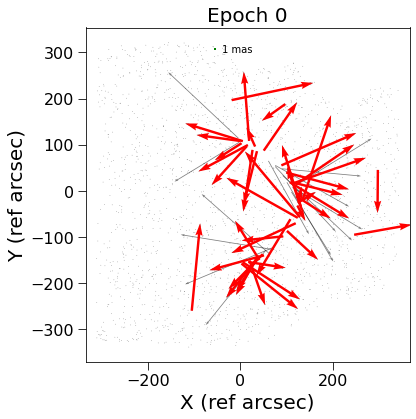

Residuals (mean, std): dx =   3.118 +/-  65.529 mas  dy =  -1.405 +/-  61.238 mas for REF stars
Residuals (mean, std): dx =   0.151 +/-  13.261 mas  dy =  -0.335 +/-  11.661 mas for GOOD stars


In [33]:
plots.plot_quiver_residuals_all_epochs(tab2_t, scale=500)

In [37]:
print(run2.trans_list[0].px.c1_0, run2.trans_list[0].py.c0_1)

Parameter('c1_0', value=0.12501371801519634) Parameter('c0_1', value=0.1354951829349439)


## Plate Scale Results

Derive the plate scales from the transformations above.

In [50]:
print('X Plate Scale = {0:5.1f} mas / pixel'.format(run2.trans_list[0].px.c1_0.value*1e3))
print('Y Plate Scale = {0:5.1f} mas / pixel'.format(run2.trans_list[0].py.c0_1.value*1e3))

X Plate Scale = 125.0 mas / pixel
Y Plate Scale = 135.5 mas / pixel
